In [ ]:

      
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import contextlib
import json
import os

# 定义一个辅助函数，用于格式化 p 值
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# 打开 Excel 文件并读取数据
df = pd.read_excel('output/Stroop-baseline-completed.xlsx')

# 定义 bootstrap 函数，参数 mediator 表示中介变量名称（a, v, t, z）
def bootstrap_indirect_effect(data, mediator, n_boot=3000, seed=42):
    np.random.seed(seed)
    boot_effects = []
    n = len(data)
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        # 重新拟合模型，自变量为Age
        mod_m = smf.ols(f'Q("{mediator}") ~ Age', data=sample).fit()
        mod_y = smf.ols(f'Incongruent ~ Age + Q("{mediator}")', data=sample).fit()
        
        a = mod_m.params['Age']
        b = mod_y.params[f'Q("{mediator}")']
        boot_effects.append(a * b)
    lower = np.percentile(boot_effects, 2.5)
    upper = np.percentile(boot_effects, 97.5)
    boot_effects = np.array(boot_effects)
    # 双尾检验 p 值计算
    p_value_indirect = 2 * min(np.mean(boot_effects < 0), np.mean(boot_effects > 0))
    p_value_indirect = min(p_value_indirect, 1.0)
    return lower, upper, p_value_indirect

# 修改：增加同时考虑多个中介变量的函数
def bootstrap_parallel_indirect_effects(data, mediators, n_boot=5000, seed=42):
    np.random.seed(seed)
    n = len(data)
    boot_effects_dict = {m: [] for m in mediators}
    boot_total_indirect = []
    
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        total_indirect = 0
        
        for mediator in mediators:
            mod_m = smf.ols(f'Q("{mediator}") ~ Age', data=sample).fit()
            mod_y = smf.ols(f'Incongruent ~ Age + Q("{mediator}")', data=sample).fit()
            
            a = mod_m.params['Age']
            b = mod_y.params[f'Q("{mediator}")']
            indirect = a * b
            boot_effects_dict[mediator].append(indirect)
            total_indirect += indirect
        
        boot_total_indirect.append(total_indirect)
    
    results = {}
    for mediator in mediators:
        effects = np.array(boot_effects_dict[mediator])
        lower = np.percentile(effects, 2.5)
        upper = np.percentile(effects, 97.5)
        p_value = 2 * min(np.mean(effects < 0), np.mean(effects > 0))
        p_value = min(p_value, 1.0)
        results[mediator] = {'lower': lower, 'upper': upper, 'p_value': p_value}
    
    # 总间接效应
    total_effects = np.array(boot_total_indirect)
    total_lower = np.percentile(total_effects, 2.5)
    total_upper = np.percentile(total_effects, 97.5)
    total_p_value = 2 * min(np.mean(total_effects < 0), np.mean(total_effects > 0))
    total_p_value = min(total_p_value, 1.0)
    results['total'] = {'lower': total_lower, 'upper': total_upper, 'p_value': total_p_value}
    
    # 计算中介变量之间的效应大小差异
    for i, m1 in enumerate(mediators):
        for j, m2 in enumerate(mediators):
            if i < j:  # 避免重复比较
                diff = np.array(boot_effects_dict[m1]) - np.array(boot_effects_dict[m2])
                diff_p_value = 2 * min(np.mean(diff < 0), np.mean(diff > 0))
                diff_p_value = min(diff_p_value, 1.0)
                results[f'{m1}_vs_{m2}'] = {
                    'diff_p_value': diff_p_value,
                    'mean_diff': np.mean(diff)
                }
    
    return results

# 创建输出目录
if not os.path.exists("output"):
    os.makedirs("output")

# 将所有 print 输出整合保存到 txt 文件中
with open('output/print_output.txt', 'w', encoding='utf-8') as f:
    with contextlib.redirect_stdout(f):
        # 查看数据的列名，确保与代码中变量名一致
        print("数据列名：", df.columns.tolist())

        # 计算总效应模型（不含中介变量）
        total_effect_model = smf.ols('Incongruent ~ Age', data=df).fit()
        print("\n总效应模型 (Incongruent ~ Age):")
        print(total_effect_model.summary())
        
        total_effect_coef = total_effect_model.params['Age']
        total_effect_p = total_effect_model.pvalues['Age']
        print(f"\n总效应 (Total Effect) = {total_effect_coef:.4f}, p = {fmt_p(total_effect_p)}")
        
        # 循环分析中介变量，分别为 a, v, t, z
        mediators = ["a", "v", "t", "z"]
        indirect_effects = {}
        direct_effects = {}
        proportion_mediated = {}
        all_model_results = {}
        
        for mediator in mediators:
            print("\n---------------------")
            print(f"中介变量： {mediator}")
            print("---------------------\n")
            
            # 中介模型：检验 Age 对 mediator 的影响
            model_m = smf.ols(f'Q("{mediator}") ~ Age', data=df).fit()
            print(f"中介模型 (M ~ Age) 结果 for {mediator}:")
            print(model_m.summary())
            
            # 因变量模型：检验 Age 和 mediator 对 Incongruent 的影响
            model_y = smf.ols(f'Incongruent ~ Age + Q("{mediator}")', data=df).fit()
            print(f"\n因变量模型 (Incongruent ~ Age + M) 结果 for {mediator}:")
            print(model_y.summary())
            
            # 提取回归系数
            a_coef = model_m.params['Age']   # Age 对 mediator 的效应（路径 a）
            p_value_a = model_m.pvalues['Age']
            
            b_coef = model_y.params[f'Q("{mediator}")']  # mediator 对 Incongruent 的效应（路径 b）
            p_value_b = model_y.pvalues[f'Q("{mediator}")']
            
            direct_effect = model_y.params['Age']  # 直接效应（路径 c'）
            p_value_c = model_y.pvalues['Age']
            
            # 计算间接效应 a * b
            indirect_effect = a_coef * b_coef
            
            # 存储结果用于后续比较
            indirect_effects[mediator] = indirect_effect
            direct_effects[mediator] = direct_effect
            proportion_mediated[mediator] = (indirect_effect / total_effect_coef) * 100
            
            # 存储模型结果用于作图
            all_model_results[mediator] = {
                'a_coef': a_coef,
                'p_value_a': p_value_a,
                'b_coef': b_coef, 
                'p_value_b': p_value_b,
                'direct_effect': direct_effect,
                'p_value_c': p_value_c,
                'indirect_effect': indirect_effect,
                'proportion': proportion_mediated[mediator]
            }
            
            print(f"\n【结果：{mediator}】")
            print("间接效应 (Indirect Effect) = {:.4f}".format(indirect_effect))
            print("直接效应 (Direct Effect) = {:.4f}".format(direct_effect))
            print("总效应 (Total Effect) = {:.4f}".format(total_effect_coef))
            print("中介效应占总效应的百分比: {:.2f}%".format(proportion_mediated[mediator]))
            
            # Bootstrap 计算间接效应置信区间和 p 值
            ci_lower, ci_upper, p_value_indirect = bootstrap_indirect_effect(df, mediator=mediator, n_boot=300, seed=42)
            print("\nBootstrap 置信区间 (95%) 的间接效应: {:.4f} [{:.4f}, {:.4f}]".format(indirect_effect, ci_lower, ci_upper))
            print("间接效应的 p 值: {}".format(fmt_p(p_value_indirect)))
            
            # 保存bootstrap结果
            all_model_results[mediator]['ci_lower'] = ci_lower
            all_model_results[mediator]['ci_upper'] = ci_upper
            all_model_results[mediator]['p_value_indirect'] = p_value_indirect
        
        # 中介效应比较
        print("\n\n---------------------")
        print("中介效应比较")
        print("---------------------")
        for mediator in mediators:
            print(f"{mediator}: 间接效应 = {indirect_effects[mediator]:.4f}, 占总效应的 {proportion_mediated[mediator]:.2f}%")
        
        # 找出最强的中介效应
        strongest_mediator = max(proportion_mediated, key=proportion_mediated.get)
        print(f"\n最强的中介效应是 {strongest_mediator}，占总效应的 {proportion_mediated[strongest_mediator]:.2f}%")
        
        # 多重中介效应分析（并行中介分析）
        print("\n\n---------------------")
        print("多重中介效应分析（并行）")
        print("---------------------")
        
        # 构建包含所有中介变量的模型
        formula_all_mediators = 'Incongruent ~ Age + ' + ' + '.join([f'Q("{m}")' for m in mediators])
        model_all = smf.ols(formula_all_mediators, data=df).fit()
        print("\n包含所有中介变量的模型:")
        print(model_all.summary())
        
        # 使用Bootstrap计算并行中介效应
        parallel_results = bootstrap_parallel_indirect_effects(df, mediators)
        
        print("\n并行中介效应结果:")
        for mediator in mediators:
            result = parallel_results[mediator]
            print(f"\n{mediator}:")
            print(f"Bootstrap 置信区间 (95%): [{result['lower']:.4f}, {result['upper']:.4f}]")
            print(f"p 值: {fmt_p(result['p_value'])}")
        
        print("\n总间接效应:")
        total_result = parallel_results['total']
        print(f"Bootstrap 置信区间 (95%): [{total_result['lower']:.4f}, {total_result['upper']:.4f}]")
        print(f"p 值: {fmt_p(total_result['p_value'])}")
        
        # 中介效应的差异检验
        print("\n中介效应差异检验:")
        for key, result in parallel_results.items():
            if '_vs_' in key:
                m1, m2 = key.split('_vs_')
                print(f"{m1} vs {m2}:")
                print(f"平均差异: {result['mean_diff']:.4f}")
                print(f"差异的 p 值: {fmt_p(result['diff_p_value'])}")

        # 保存用于作图的结果数据
        results_for_plotting = {
            'total_effect': total_effect_coef,
            'total_effect_p': total_effect_p,
            'strongest_mediator': strongest_mediator,
            'model_results': all_model_results,
            'indirect_effects': indirect_effects,
            'direct_effects': direct_effects, 
            'proportion_mediated': proportion_mediated,
            'parallel_results': parallel_results
        }

        # 保存结果为JSON文件
        with open('output/model_results-dvalue.json', 'w', encoding='utf-8') as json_file:
            # 将不能直接序列化的numpy类型转换为Python类型
            def convert_numpy(obj):
                if isinstance(obj, np.integer):
                    return int(obj)
                elif isinstance(obj, np.floating):
                    return float(obj)
                elif isinstance(obj, np.ndarray):
                    return obj.tolist()
                return obj
            
            # 使用自定义转换函数序列化JSON
            json.dump(results_for_plotting, json_file, default=convert_numpy, indent=4)

print("计算完成！结果已保存到 output 目录下。")


计算完成！结果已保存到 output 目录下。


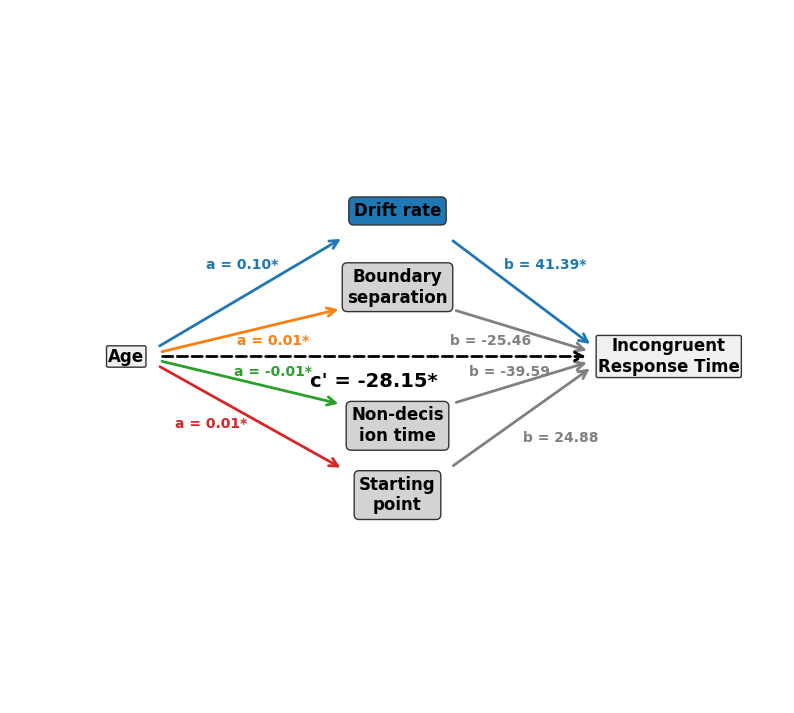

In [8]:

import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np

# Function for formatting p-values
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# Create directory for saving plots
if not os.path.exists("output"):
    os.makedirs("output")

# Read analysis results
with open('output/model_results-dvalue.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# Extract required data
total_effect_coef = results['total_effect']
total_effect_p = results['total_effect_p']
strongest_mediator = results['strongest_mediator']
model_results = results['model_results']
indirect_effects = results['indirect_effects']
direct_effects = results['direct_effects']
proportion_mediated = results['proportion_mediated']
parallel_results = results['parallel_results']

# List of mediators
mediators = list(model_results.keys())

# Define color scheme
mediator_colors = {
    'v': '#1f77b4',
    'a': '#ff7f0e',
    't': '#2ca02c',
    'z': '#d62728'
}

mediator_labels = {
    'v': 'Drift rate',
    'a': 'Boundary\nseparation',
    't': 'Non-decis\nion time',
    'z': 'Starting\npoint'
}

node_facecolor = "#f0f0f0"
node_edgecolor = "#333333"
arrow_color = "#1f77b4"
direct_arrow_color = "#ff7f0e"

# 3. Draw combined mediation model visualization
plt.figure(figsize=(10, 9))

# 定义节点位置
positions = {
    'X': (0.15, 0.5),   # X node position
    'Y': (0.85, 0.5),   # Y node position
    'v': (0.5, 0.71),    # v mediator position
    'a': (0.5, 0.60),    # a mediator position
    't': (0.5, 0.4),    # t mediator position
    'z': (0.5, 0.3)     # z mediator position
}

# Node dimensions parameters
node_width = 0.12       # Width of node boxes
node_height = 0.07      # Height of node boxes
main_node_pad = 0.1     # Padding for main nodes (X, Y)
mediator_node_pad = 0.3 # Padding for mediator nodes

# Arrow parameters
arrow_shrink_a = 15     # How much to shrink arrows at start point
arrow_shrink_b = 15     # How much to shrink arrows at end point
arrow_width = 2         # Line width for arrows
arrow_head_size = 15    # Size of arrowheads

# Mediator node offset parameters (distance from node edge to arrow)
mediator_offset = 0.05 # Distance from mediator node to arrow start/end

# Text position adjustment parameters
a_text_offset_x = {     # X offset for 'a' coefficient text
    'v': -0.01,
    'a': 0.03,
    't': 0.03,
    'z': -0.05
}
a_text_offset_y = {     # Y offset for 'a' coefficient text
    'v': 0.04,
    'a': -0.015,
    't': 0.015,
    'z': -0.01
}
b_text_offset_x = {     # X offset for 'b' coefficient text
    'v': 0.03,
    'a': -0.04,
    't': -0.015,
    'z': 0.05
}
b_text_offset_y = {     # Y offset for 'b' coefficient text
    'v': 0.04,
    'a': -0.015,
    't': 0.015,
    'z': -0.03
}

c_text_offset_y = -0.05 # Y offset for 'c' coefficient text

# Function to get the coordinates of node edges
def get_edge_point(from_node, to_node):
    # Calculate direction vector
    dx = positions[to_node][0] - positions[from_node][0]
    dy = positions[to_node][1] - positions[from_node][1]
    
    # Normalize
    length = np.sqrt(dx**2 + dy**2)
    dx = dx / length
    dy = dy / length
    
    # Adjust starting position based on node dimensions
    if from_node in ['X', 'Y']:
        # For main nodes (X, Y), consider their rectangular shape
        if abs(dx) > abs(dy):  # Horizontal predominant direction
            # If moving right
            if dx > 0:
                start_x = positions[from_node][0] + node_width - 0.1
            # If moving left
            else:
                start_x = positions[from_node][0] 
            start_y = positions[from_node][1]
        else:  # Vertical predominant direction
            start_x = positions[from_node][0]
            # If moving up
            if dy > 0:
                start_y = positions[from_node][1] + node_height
            # If moving down
            else:
                start_y = positions[from_node][1] - node_height
    else:
        # For mediator nodes, add offset to ensure gap between node and arrow
        if dx > 0:  # Moving right (towards Y)
            start_x = positions[from_node][0] + mediator_offset
        else:  # Moving left (towards X)
            start_x = positions[from_node][0] - mediator_offset
        
        if dy > 0:  # Moving up
            start_y = positions[from_node][1] + mediator_offset / 2
        elif dy < 0:  # Moving down
            start_y = positions[from_node][1] - mediator_offset / 2
        else:  # Horizontal only
            start_y = positions[from_node][1]
    
    # Adjust ending position based on node dimensions
    if to_node in ['X', 'Y']:
        # For main nodes (X, Y), consider their rectangular shape
        if abs(dx) > abs(dy):  # Horizontal predominant direction
            # If moving right
            if dx > 0:
                end_x = positions[to_node][0] - node_width + 0.04
            # If moving left
            else:
                end_x = positions[to_node][0] + node_width
            end_y = positions[to_node][1]
        else:  # Vertical predominant direction
            end_x = positions[to_node][0]
            # If moving up
            if dy > 0:
                end_y = positions[to_node][1] - node_height
            # If moving down
            else:
                end_y = positions[to_node][1] + node_height
    else:
        # For mediator nodes, add offset to ensure gap between node and arrow
        if dx > 0:  # Moving right
            end_x = positions[to_node][0] - mediator_offset
        else:  # Moving left
            end_x = positions[to_node][0] + mediator_offset
            
        if dy > 0:  # Moving up
            end_y = positions[to_node][1] - mediator_offset / 2
        elif dy < 0:  # Moving down
            end_y = positions[to_node][1] + mediator_offset / 2
        else:  # Horizontal only
            end_y = positions[to_node][1]
        
    return (start_x, start_y), (end_x, end_y)

# Draw nodes
for node, pos in positions.items():
    if node == 'X':
        label = 'Age'
        color = node_facecolor
        bbox_pad = main_node_pad  # Larger padding for main nodes
    elif node == 'Y':
        label = 'Incongruent\nResponse Time'
        color = node_facecolor
        bbox_pad = main_node_pad  # Larger padding for main nodes
    else:  # Mediator variables
        label = mediator_labels[node]
        # Mark significant mediators with special colors
        if float(parallel_results[node]['p_value']) < 0.05:
            color = mediator_colors[node]
        else:
            color = '#d3d3d3'  # Non-significant mediators use gray
        bbox_pad = mediator_node_pad  # Regular padding for mediator nodes
    
    plt.text(pos[0], pos[1], label, 
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle=f'round,pad={bbox_pad}', fc=color, ec=node_edgecolor))

# Draw paths
# X to mediator paths
for m in mediators:
    # Determine if the path is significant
    is_sig_a = float(model_results[m]['p_value_a']) < 0.05
    path_color = mediator_colors[m] if is_sig_a else 'gray'
    
    # Get edge coordinates
    start_point, end_point = get_edge_point('X', m)
    
    # Draw the straight arrow (connectionstyle="arc3,rad=0" makes it straight)
    plt.annotate('', xy=end_point, xytext=start_point, 
                 arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0", 
                               linewidth=arrow_width, mutation_scale=arrow_head_size, 
                               shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                               color=path_color))
    
    # Add coefficient annotation for path a
    # Calculate position for text (slightly offset from the midpoint)
    midx = (start_point[0] + end_point[0]) / 2
    midy = (start_point[1] + end_point[1]) / 2
    
    # Apply text offsets
    text_x = midx + a_text_offset_x[m]
    text_y = midy + a_text_offset_y[m]
    
    # Add path a coefficient
    plt.text(text_x, text_y, 
             f"a = {model_results[m]['a_coef']:.2f}" + 
             (f"*" if is_sig_a else ""),
             ha='center', va='center', fontsize=10, color=path_color, weight='bold')

# Mediator to Y paths
for m in mediators:
    # Determine if the path is significant
    is_sig_b = float(model_results[m]['p_value_b']) < 0.05
    path_color = mediator_colors[m] if is_sig_b else 'gray'
    
    # Get edge coordinates
    start_point, end_point = get_edge_point(m, 'Y')
    
    # Draw the straight arrow
    plt.annotate('', xy=end_point, xytext=start_point, 
                 arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0", 
                               linewidth=arrow_width, mutation_scale=arrow_head_size, 
                               shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                               color=path_color))
    
    # Add coefficient annotation for path b
    # Calculate position for text (slightly offset from the midpoint)
    midx = (start_point[0] + end_point[0]) / 2
    midy = (start_point[1] + end_point[1]) / 2
    
    # Apply text offsets
    text_x = midx + b_text_offset_x[m]
    text_y = midy + b_text_offset_y[m]
    
    # Add path b coefficient
    plt.text(text_x, text_y, 
             f"b = {model_results[m]['b_coef']:.2f}" + 
             (f"*" if is_sig_b else ""),
             ha='center', va='center', fontsize=10, color=path_color, weight='bold')

# X to Y direct path (keep this as a dashed line)
start_point, end_point = get_edge_point('X', 'Y')
plt.annotate('', xy=end_point, xytext=start_point, 
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0", 
                           linewidth=arrow_width, linestyle='--', mutation_scale=arrow_head_size, 
                           shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b, color='black'))

# Add direct effect coefficient
direct_midx = (start_point[0] + end_point[0]) / 2
direct_midy = (start_point[1] + end_point[1]) / 2 + c_text_offset_y
plt.text(direct_midx, direct_midy, 
         f"c' = {direct_effects[strongest_mediator]:.2f}*",
  fontsize=14, color='black', weight='bold', ha='center', va='bottom')


# Add legend
legend_elements = []
for m in mediators:
    # Remove newline characters properly
    clean_label = mediator_labels[m].replace('\n', ' ')
    
    if float(parallel_results[m]['p_value']) < 0.05:
        legend_elements.append(
            Patch(facecolor=mediator_colors[m], 
                 label=f'{clean_label}: {proportion_mediated[m]:.1f}% (p={fmt_p(parallel_results[m]["p_value"])})')
        )
    else:
        legend_elements.append(
            Patch(facecolor='#d3d3d3', 
                 label=f'{clean_label}: {proportion_mediated[m]:.1f}% (p={fmt_p(parallel_results[m]["p_value"])})')
        )

legend_elements.append(Patch(facecolor='none', edgecolor='black', linestyle='--', 
                             label=f'Direct Effect: {direct_effects[strongest_mediator]:.2f}'))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

plt.savefig('./output/combined_mediation_model-dvalue-stroop.jpg', dpi=1200, bbox_inches='tight')
plt.show()

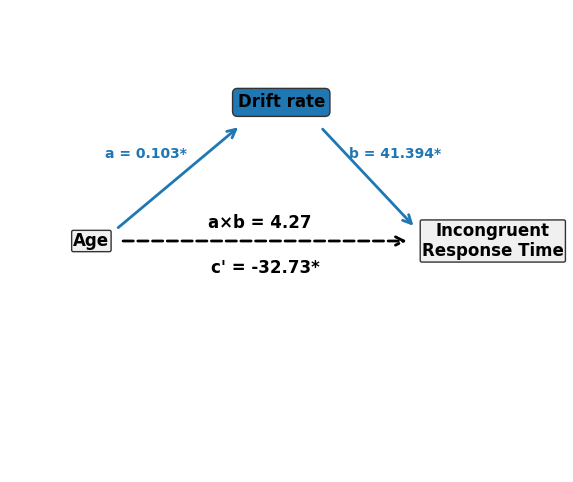

In [6]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np

# Function for formatting p-values
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# Create directory for saving plots
if not os.path.exists("output"):
    os.makedirs("output")

# Read analysis results
with open('output/model_results-dvalue.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# Extract required data
strongest_mediator = results['strongest_mediator']
model_results = results['model_results']
direct_effects = results['direct_effects']
proportion_mediated = results['proportion_mediated']
parallel_results = results['parallel_results']

# Only keep 'v' as mediator
mediators = ['v']

# Define color scheme
mediator_colors = {
    'v': '#1f77b4'
}

mediator_labels = {
    'v': 'Drift rate'
}

node_facecolor = "#f0f0f0"
node_edgecolor = "#333333"
arrow_color = "#1f77b4"
direct_arrow_color = "#ff7f0e"

# Draw combined mediation model visualization for only 'v'
plt.figure(figsize=(7, 6))

# Define node positions for just X, v, Y
positions = {
    'X': (0.15, 0.5),   # X node position
    'v': (0.5, 0.8),    # v mediator position, centered vertically
    'Y': (0.89, 0.5)    # Y node position
}

# Node dimensions parameters
node_width = 0.12       # Width of node boxes
node_height = 0.07      # Height of node boxes
main_node_pad = 0.1     # Padding for main nodes (X, Y)
mediator_node_pad = 0.3 # Padding for mediator node

# Arrow parameters
arrow_shrink_a = 15     # How much to shrink arrows at start point
arrow_shrink_b = 15     # How much to shrink arrows at end point
arrow_width = 2         # Line width for arrows
arrow_head_size = 15    # Size of arrowheads

# Mediator node offset parameter (distance from node edge to arrow)
mediator_offset = 0.05  # Distance from mediator node to arrow start/end

# Text position adjustment parameters for v
a_text_offset_x = {'v': -0.06}
a_text_offset_y = {'v': 0.05}
b_text_offset_x = {'v': 0.05}
b_text_offset_y = {'v': 0.05}

c_text_offset_y = -0.07 # Y offset for 'c' coefficient text

# Function to get the coordinates of node edges
def get_edge_point(from_node, to_node):
    # Calculate direction vector
    dx = positions[to_node][0] - positions[from_node][0]
    dy = positions[to_node][1] - positions[from_node][1]
    
    # Normalize
    length = np.sqrt(dx**2 + dy**2)
    dx = dx / length
    dy = dy / length
    
    # Adjust starting position based on node dimensions
    if from_node in ['X', 'Y']:
        # For main nodes (X, Y), consider their rectangular shape
        if abs(dx) > abs(dy):  # Horizontal predominant direction
            if dx > 0:  # moving right
                start_x = positions[from_node][0] + node_width - 0.1
            else:       # moving left
                start_x = positions[from_node][0]
            start_y = positions[from_node][1]
        else:  # Vertical predominant direction
            start_x = positions[from_node][0]
            if dy > 0:  # moving up
                start_y = positions[from_node][1] + node_height
            else:       # moving down
                start_y = positions[from_node][1] - node_height
    else:
        # For mediator node 'v', add offset to ensure gap between node and arrow
        if dx > 0:  # Moving right (towards Y)
            start_x = positions[from_node][0] + mediator_offset
        else:       # Moving left (towards X)
            start_x = positions[from_node][0] - mediator_offset
        
        if dy > 0:  # Moving up
            start_y = positions[from_node][1] + mediator_offset / 2
        elif dy < 0:  # Moving down
            start_y = positions[from_node][1] - mediator_offset / 2
        else:        # Horizontal only
            start_y = positions[from_node][1]
    
    # Adjust ending position based on node dimensions
    if to_node in ['X', 'Y']:
        if abs(dx) > abs(dy):  # Horizontal predominant direction
            if dx > 0:  # Moving right
                end_x = positions[to_node][0] - node_width + 0.0
            else:        # Moving left
                end_x = positions[to_node][0] + node_width
            end_y = positions[to_node][1]
        else:  # Vertical predominant direction
            end_x = positions[to_node][0]
            if dy > 0:  # Moving up
                end_y = positions[to_node][1] - node_height
            else:       # Moving down
                end_y = positions[to_node][1] + node_height
    else:
        # For mediator node 'v', add offset
        if dx > 0:  # Moving right
            end_x = positions[to_node][0] - mediator_offset
        else:       # Moving left
            end_x = positions[to_node][0] + mediator_offset
            
        if dy > 0:  # Moving up
            end_y = positions[to_node][1] - mediator_offset / 2
        elif dy < 0:  # Moving down
            end_y = positions[to_node][1] + mediator_offset / 2
        else:        # Horizontal only
            end_y = positions[to_node][1]
        
    return (start_x, start_y), (end_x, end_y)


# Draw nodes for X, v, Y
for node, pos in positions.items():
    if node == 'X':
        label = 'Age'
        color = node_facecolor
        bbox_pad = main_node_pad
    elif node == 'Y':
        label = 'Incongruent\nResponse Time'
        color = node_facecolor
        bbox_pad = main_node_pad
    else:  # node == 'v'
        label = mediator_labels[node]
        if float(parallel_results[node]['p_value']) < 0.05:
            color = mediator_colors[node]
        else:
            color = '#d3d3d3'  # gray if not significant
        bbox_pad = mediator_node_pad
    
    plt.text(pos[0], pos[1], label,
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle=f'round,pad={bbox_pad}', fc=color, ec=node_edgecolor))


# Draw X -> v path
m = 'v'
is_sig_a = float(model_results[m]['p_value_a']) < 0.05
path_color = mediator_colors[m] if is_sig_a else 'gray'

start_point, end_point = get_edge_point('X', m)
plt.annotate('', xy=end_point, xytext=start_point,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0",
                             linewidth=arrow_width, mutation_scale=arrow_head_size,
                             shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                             color=path_color))

# Add coefficient annotation for path a (X->v)
midx = (start_point[0] + end_point[0]) / 2
midy = (start_point[1] + end_point[1]) / 2
text_x = midx + a_text_offset_x[m]
text_y = midy + a_text_offset_y[m]
plt.text(text_x, text_y,
         f"a = {model_results[m]['a_coef']:.3f}" + (f"*" if is_sig_a else ""),
         ha='center', va='center', fontsize=10, color=path_color, weight='bold')


# Draw v -> Y path
is_sig_b = float(model_results[m]['p_value_b']) < 0.05
path_color = mediator_colors[m] if is_sig_b else 'gray'

start_point, end_point = get_edge_point(m, 'Y')
plt.annotate('', xy=end_point, xytext=start_point,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0",
                             linewidth=arrow_width, mutation_scale=arrow_head_size,
                             shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                             color=path_color))

# Add coefficient annotation for path b (v->Y)
midx = (start_point[0] + end_point[0]) / 2
midy = (start_point[1] + end_point[1]) / 2
text_x = midx + b_text_offset_x[m]
text_y = midy + b_text_offset_y[m]
plt.text(text_x, text_y,
         f"b = {model_results[m]['b_coef']:.3f}" + (f"*" if is_sig_b else ""),
         ha='center', va='center', fontsize=10, color=path_color, weight='bold')


# Add a × b annotation above v
a_coef = model_results[m]['a_coef']
b_coef = model_results[m]['b_coef']
ab_value = a_coef * b_coef
ab_text = f"a×b = {ab_value:.2f}"
# Position slightly above the mediator node
med_x, med_y = positions['v']
plt.text(med_x- 0.04, med_y - 0.26, ab_text, ha='center', va='center', fontsize=12, fontweight='bold')


# Draw X -> Y direct path (dashed)
start_point, end_point = get_edge_point('X', 'Y')
plt.annotate('', xy=end_point, xytext=start_point,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0",
                             linewidth=arrow_width, linestyle='--', mutation_scale=arrow_head_size,
                             shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b, color='black'))

# Add direct effect coefficient c'
direct_midx = (start_point[0] + end_point[0]) / 2
direct_midy = (start_point[1] + end_point[1]) / 2 + c_text_offset_y
plt.text(direct_midx, direct_midy,
         f"c' = {direct_effects[m]:.2f}*",
         fontsize=12, color='black', weight='bold', ha='center')


# Add legend for v
legend_elements = []
clean_label = mediator_labels['v'].replace('\n', ' ')
if float(parallel_results['v']['p_value']) < 0.05:
    legend_elements.append(
        Patch(facecolor=mediator_colors['v'],
               label=f'{clean_label}: {proportion_mediated["v"]:.1f}% (p={fmt_p(parallel_results["v"]["p_value"])})')
    )
else:
    legend_elements.append(
        Patch(facecolor='#d3d3d3',
               label=f'{clean_label}: {proportion_mediated["v"]:.1f}% (p={fmt_p(parallel_results["v"]["p_value"])})')
    )

legend_elements.append(
    Patch(facecolor='none', edgecolor='black', linestyle='--',
          label=f'Direct Effect: {direct_effects["v"]:.2f}')
)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

plt.savefig('./output/v_mediation_model-stroop.jpg', dpi=1200, bbox_inches='tight')
plt.show()

计算完成！结果已保存到 output 目录下。


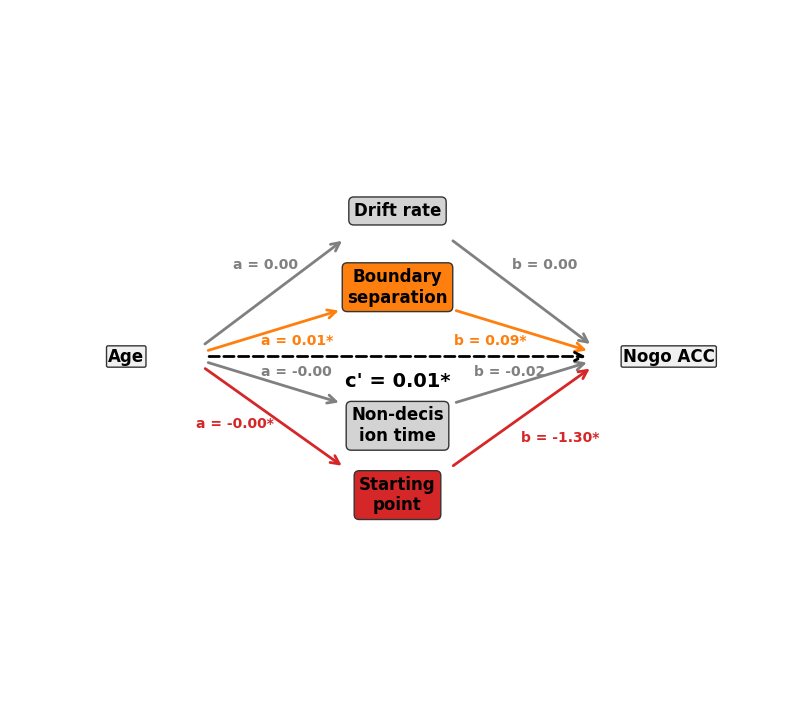

In [52]:
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import contextlib
import json
import os

# 定义一个辅助函数，用于格式化 p 值
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# 打开 Excel 文件并读取数据
df = pd.read_excel('Gonogo-baseline-avtz.xlsx')

# 定义 bootstrap 函数，参数 mediator 表示中介变量名称（a, v, t, z）
def bootstrap_indirect_effect(data, mediator, n_boot=3000, seed=42):
    np.random.seed(seed)
    boot_effects = []
    n = len(data)
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        # 重新拟合模型，自变量为Age
        mod_m = smf.ols(f'Q("{mediator}") ~ Age', data=sample).fit()
        mod_y = smf.ols(f'Nogo_ACC ~ Age + Q("{mediator}")', data=sample).fit()
        
        a = mod_m.params['Age']
        b = mod_y.params[f'Q("{mediator}")']
        boot_effects.append(a * b)
    lower = np.percentile(boot_effects, 2.5)
    upper = np.percentile(boot_effects, 97.5)
    boot_effects = np.array(boot_effects)
    # 双尾检验 p 值计算
    p_value_indirect = 2 * min(np.mean(boot_effects < 0), np.mean(boot_effects > 0))
    p_value_indirect = min(p_value_indirect, 1.0)
    return lower, upper, p_value_indirect

# 修改：增加同时考虑多个中介变量的函数
def bootstrap_parallel_indirect_effects(data, mediators, n_boot=5000, seed=42):
    np.random.seed(seed)
    n = len(data)
    boot_effects_dict = {m: [] for m in mediators}
    boot_total_indirect = []
    
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        total_indirect = 0
        
        for mediator in mediators:
            mod_m = smf.ols(f'Q("{mediator}") ~ Age', data=sample).fit()
            mod_y = smf.ols(f'Nogo_ACC ~ Age + Q("{mediator}")', data=sample).fit()
            
            a = mod_m.params['Age']
            b = mod_y.params[f'Q("{mediator}")']
            indirect = a * b
            boot_effects_dict[mediator].append(indirect)
            total_indirect += indirect
        
        boot_total_indirect.append(total_indirect)
    
    results = {}
    for mediator in mediators:
        effects = np.array(boot_effects_dict[mediator])
        lower = np.percentile(effects, 2.5)
        upper = np.percentile(effects, 97.5)
        p_value = 2 * min(np.mean(effects < 0), np.mean(effects > 0))
        p_value = min(p_value, 1.0)
        results[mediator] = {'lower': lower, 'upper': upper, 'p_value': p_value}
    
    # 总间接效应
    total_effects = np.array(boot_total_indirect)
    total_lower = np.percentile(total_effects, 2.5)
    total_upper = np.percentile(total_effects, 97.5)
    total_p_value = 2 * min(np.mean(total_effects < 0), np.mean(total_effects > 0))
    total_p_value = min(total_p_value, 1.0)
    results['total'] = {'lower': total_lower, 'upper': total_upper, 'p_value': total_p_value}
    
    # 计算中介变量之间的效应大小差异
    for i, m1 in enumerate(mediators):
        for j, m2 in enumerate(mediators):
            if i < j:  # 避免重复比较
                diff = np.array(boot_effects_dict[m1]) - np.array(boot_effects_dict[m2])
                diff_p_value = 2 * min(np.mean(diff < 0), np.mean(diff > 0))
                diff_p_value = min(diff_p_value, 1.0)
                results[f'{m1}_vs_{m2}'] = {
                    'diff_p_value': diff_p_value,
                    'mean_diff': np.mean(diff)
                }
    
    return results

# 创建输出目录
if not os.path.exists("output"):
    os.makedirs("output")

# 将所有 print 输出整合保存到 txt 文件中
with open('output/print_output.txt', 'w', encoding='utf-8') as f:
    with contextlib.redirect_stdout(f):
        # 查看数据的列名，确保与代码中变量名一致
        print("数据列名：", df.columns.tolist())

        # 计算总效应模型（不含中介变量）
        total_effect_model = smf.ols('Nogo_ACC ~ Age', data=df).fit()
        print("\n总效应模型 (Nogo_ACC ~ Age):")
        print(total_effect_model.summary())
        
        total_effect_coef = total_effect_model.params['Age']
        total_effect_p = total_effect_model.pvalues['Age']
        print(f"\n总效应 (Total Effect) = {total_effect_coef:.4f}, p = {fmt_p(total_effect_p)}")
        
        # 循环分析中介变量，分别为 a, v, t, z
        mediators = ["a", "v", "t", "z"]
        indirect_effects = {}
        direct_effects = {}
        proportion_mediated = {}
        all_model_results = {}
        
        for mediator in mediators:
            print("\n---------------------")
            print(f"中介变量： {mediator}")
            print("---------------------\n")
            
            # 中介模型：检验 Age 对 mediator 的影响
            model_m = smf.ols(f'Q("{mediator}") ~ Age', data=df).fit()
            print(f"中介模型 (M ~ Age) 结果 for {mediator}:")
            print(model_m.summary())
            
            # 因变量模型：检验 Age 和 mediator 对 Nogo_ACC 的影响
            model_y = smf.ols(f'Nogo_ACC ~ Age + Q("{mediator}")', data=df).fit()
            print(f"\n因变量模型 (Nogo_ACC ~ Age + M) 结果 for {mediator}:")
            print(model_y.summary())
            
            # 提取回归系数
            a_coef = model_m.params['Age']   # Age 对 mediator 的效应（路径 a）
            p_value_a = model_m.pvalues['Age']
            
            b_coef = model_y.params[f'Q("{mediator}")']  # mediator 对 Nogo_ACC 的效应（路径 b）
            p_value_b = model_y.pvalues[f'Q("{mediator}")']
            
            direct_effect = model_y.params['Age']  # 直接效应（路径 c'）
            p_value_c = model_y.pvalues['Age']
            
            # 计算间接效应 a * b
            indirect_effect = a_coef * b_coef
            
            # 存储结果用于后续比较
            indirect_effects[mediator] = indirect_effect
            direct_effects[mediator] = direct_effect
            proportion_mediated[mediator] = (indirect_effect / total_effect_coef) * 100
            
            # 存储模型结果用于作图
            all_model_results[mediator] = {
                'a_coef': a_coef,
                'p_value_a': p_value_a,
                'b_coef': b_coef, 
                'p_value_b': p_value_b,
                'direct_effect': direct_effect,
                'p_value_c': p_value_c,
                'indirect_effect': indirect_effect,
                'proportion': proportion_mediated[mediator]
            }
            
            print(f"\n【结果：{mediator}】")
            print("间接效应 (Indirect Effect) = {:.4f}".format(indirect_effect))
            print("直接效应 (Direct Effect) = {:.4f}".format(direct_effect))
            print("总效应 (Total Effect) = {:.4f}".format(total_effect_coef))
            print("中介效应占总效应的百分比: {:.2f}%".format(proportion_mediated[mediator]))
            
            # Bootstrap 计算间接效应置信区间和 p 值
            ci_lower, ci_upper, p_value_indirect = bootstrap_indirect_effect(df, mediator=mediator, n_boot=5000, seed=42)
            print("\nBootstrap 置信区间 (95%) 的间接效应: {:.4f} [{:.4f}, {:.4f}]".format(indirect_effect, ci_lower, ci_upper))
            print("间接效应的 p 值: {}".format(fmt_p(p_value_indirect)))
            
            # 保存bootstrap结果
            all_model_results[mediator]['ci_lower'] = ci_lower
            all_model_results[mediator]['ci_upper'] = ci_upper
            all_model_results[mediator]['p_value_indirect'] = p_value_indirect
        
        # 中介效应比较
        print("\n\n---------------------")
        print("中介效应比较")
        print("---------------------")
        for mediator in mediators:
            print(f"{mediator}: 间接效应 = {indirect_effects[mediator]:.4f}, 占总效应的 {proportion_mediated[mediator]:.2f}%")
        
        # 找出最强的中介效应
        strongest_mediator = max(proportion_mediated, key=proportion_mediated.get)
        print(f"\n最强的中介效应是 {strongest_mediator}，占总效应的 {proportion_mediated[strongest_mediator]:.2f}%")
        
        # 多重中介效应分析（并行中介分析）
        print("\n\n---------------------")
        print("多重中介效应分析（并行）")
        print("---------------------")
        
        # 构建包含所有中介变量的模型
        formula_all_mediators = 'Nogo_ACC ~ Age + ' + ' + '.join([f'Q("{m}")' for m in mediators])
        model_all = smf.ols(formula_all_mediators, data=df).fit()
        print("\n包含所有中介变量的模型:")
        print(model_all.summary())
        
        # 使用Bootstrap计算并行中介效应
        parallel_results = bootstrap_parallel_indirect_effects(df, mediators)
        
        print("\n并行中介效应结果:")
        for mediator in mediators:
            result = parallel_results[mediator]
            print(f"\n{mediator}:")
            print(f"Bootstrap 置信区间 (95%): [{result['lower']:.4f}, {result['upper']:.4f}]")
            print(f"p 值: {fmt_p(result['p_value'])}")
        
        print("\n总间接效应:")
        total_result = parallel_results['total']
        print(f"Bootstrap 置信区间 (95%): [{total_result['lower']:.4f}, {total_result['upper']:.4f}]")
        print(f"p 值: {fmt_p(total_result['p_value'])}")
        
        # 中介效应的差异检验
        print("\n中介效应差异检验:")
        for key, result in parallel_results.items():
            if '_vs_' in key:
                m1, m2 = key.split('_vs_')
                print(f"{m1} vs {m2}:")
                print(f"平均差异: {result['mean_diff']:.4f}")
                print(f"差异的 p 值: {fmt_p(result['diff_p_value'])}")

        # 保存用于作图的结果数据
        results_for_plotting = {
            'total_effect': total_effect_coef,
            'total_effect_p': total_effect_p,
            'strongest_mediator': strongest_mediator,
            'model_results': all_model_results,
            'indirect_effects': indirect_effects,
            'direct_effects': direct_effects, 
            'proportion_mediated': proportion_mediated,
            'parallel_results': parallel_results
        }

        # 保存结果为JSON文件
        with open('output/model_results-dvalue-gonogo.json', 'w', encoding='utf-8') as json_file:
            # 将不能直接序列化的numpy类型转换为Python类型
            def convert_numpy(obj):
                if isinstance(obj, np.integer):
                    return int(obj)
                elif isinstance(obj, np.floating):
                    return float(obj)
                elif isinstance(obj, np.ndarray):
                    return obj.tolist()
                return obj
            
            # 使用自定义转换函数序列化JSON
            json.dump(results_for_plotting, json_file, default=convert_numpy, indent=4)

print("计算完成！结果已保存到 output 目录下。")

import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np

# Function for formatting p-values
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# Create directory for saving plots
if not os.path.exists("output"):
    os.makedirs("output")

# Read analysis results
with open('output/model_results-dvalue-gonogo.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# Extract required data
total_effect_coef = results['total_effect']
total_effect_p = results['total_effect_p']
strongest_mediator = results['strongest_mediator']
model_results = results['model_results']
indirect_effects = results['indirect_effects']
direct_effects = results['direct_effects']
proportion_mediated = results['proportion_mediated']
parallel_results = results['parallel_results']

# List of mediators
mediators = list(model_results.keys())

# Define color scheme
mediator_colors = {
    'v': '#1f77b4',
    'a': '#ff7f0e',
    't': '#2ca02c',
    'z': '#d62728'
}

mediator_labels = {
    'v': 'Drift rate',
    'a': 'Boundary\nseparation',
    't': 'Non-decis\nion time',
    'z': 'Starting\npoint'
}

node_facecolor = "#f0f0f0"
node_edgecolor = "#333333"
arrow_color = "#1f77b4"
direct_arrow_color = "#ff7f0e"

# 3. Draw combined mediation model visualization
plt.figure(figsize=(10, 9))

# 定义节点位置
positions = {
    'X': (0.15, 0.5),   # X node position
    'Y': (0.85, 0.5),   # Y node position
    'v': (0.5, 0.71),    # v mediator position
    'a': (0.5, 0.60),    # a mediator position
    't': (0.5, 0.4),    # t mediator position
    'z': (0.5, 0.3)     # z mediator position
}

# Node dimensions parameters
node_width = 0.12       # Width of node boxes
node_height = 0.07      # Height of node boxes
main_node_pad = 0.1     # Padding for main nodes (X, Y)
mediator_node_pad = 0.3 # Padding for mediator nodes

# Arrow parameters
arrow_shrink_a = 15     # How much to shrink arrows at start point
arrow_shrink_b = 15     # How much to shrink arrows at end point
arrow_width = 2         # Line width for arrows
arrow_head_size = 15    # Size of arrowheads

# Mediator node offset parameters (distance from node edge to arrow)
mediator_offset = 0.05 # Distance from mediator node to arrow start/end

# Text position adjustment parameters
a_text_offset_x = {     # X offset for 'a' coefficient text
    'v': -0.01,
    'a': 0.03,
    't': 0.03,
    'z': -0.05
}
a_text_offset_y = {     # Y offset for 'a' coefficient text
    'v': 0.04,
    'a': -0.015,
    't': 0.015,
    'z': -0.01
}
b_text_offset_x = {     # X offset for 'b' coefficient text
    'v': 0.03,
    'a': -0.04,
    't': -0.015,
    'z': 0.05
}
b_text_offset_y = {     # Y offset for 'b' coefficient text
    'v': 0.04,
    'a': -0.015,
    't': 0.015,
    'z': -0.03
}

c_text_offset_y = -0.05 # Y offset for 'c' coefficient text

# Function to get the coordinates of node edges
def get_edge_point(from_node, to_node):
    # Calculate direction vector
    dx = positions[to_node][0] - positions[from_node][0]
    dy = positions[to_node][1] - positions[from_node][1]
    
    # Normalize
    length = np.sqrt(dx**2 + dy**2)
    dx = dx / length
    dy = dy / length
    
    # Adjust starting position based on node dimensions
    if from_node in ['X', 'Y']:
        # For main nodes (X, Y), consider their rectangular shape
        if abs(dx) > abs(dy):  # Horizontal predominant direction
            # If moving right
            if dx > 0:
                start_x = positions[from_node][0] + node_width - 0.04
            # If moving left
            else:
                start_x = positions[from_node][0] 
            start_y = positions[from_node][1]
        else:  # Vertical predominant direction
            start_x = positions[from_node][0]
            # If moving up
            if dy > 0:
                start_y = positions[from_node][1] + node_height
            # If moving down
            else:
                start_y = positions[from_node][1] - node_height
    else:
        # For mediator nodes, add offset to ensure gap between node and arrow
        if dx > 0:  # Moving right (towards Y)
            start_x = positions[from_node][0] + mediator_offset
        else:  # Moving left (towards X)
            start_x = positions[from_node][0] - mediator_offset
        
        if dy > 0:  # Moving up
            start_y = positions[from_node][1] + mediator_offset / 2
        elif dy < 0:  # Moving down
            start_y = positions[from_node][1] - mediator_offset / 2
        else:  # Horizontal only
            start_y = positions[from_node][1]
    
    # Adjust ending position based on node dimensions
    if to_node in ['X', 'Y']:
        # For main nodes (X, Y), consider their rectangular shape
        if abs(dx) > abs(dy):  # Horizontal predominant direction
            # If moving right
            if dx > 0:
                end_x = positions[to_node][0] - node_width + 0.04
            # If moving left
            else:
                end_x = positions[to_node][0] + node_width
            end_y = positions[to_node][1]
        else:  # Vertical predominant direction
            end_x = positions[to_node][0]
            # If moving up
            if dy > 0:
                end_y = positions[to_node][1] - node_height
            # If moving down
            else:
                end_y = positions[to_node][1] + node_height
    else:
        # For mediator nodes, add offset to ensure gap between node and arrow
        if dx > 0:  # Moving right
            end_x = positions[to_node][0] - mediator_offset
        else:  # Moving left
            end_x = positions[to_node][0] + mediator_offset
            
        if dy > 0:  # Moving up
            end_y = positions[to_node][1] - mediator_offset / 2
        elif dy < 0:  # Moving down
            end_y = positions[to_node][1] + mediator_offset / 2
        else:  # Horizontal only
            end_y = positions[to_node][1]
        
    return (start_x, start_y), (end_x, end_y)

# Draw nodes
for node, pos in positions.items():
    if node == 'X':
        label = 'Age'
        color = node_facecolor
        bbox_pad = main_node_pad  # Larger padding for main nodes
    elif node == 'Y':
        label = 'Nogo ACC'
        color = node_facecolor
        bbox_pad = main_node_pad  # Larger padding for main nodes
    else:  # Mediator variables
        label = mediator_labels[node]
        # Mark significant mediators with special colors
        if float(parallel_results[node]['p_value']) < 0.05:
            color = mediator_colors[node]
        else:
            color = '#d3d3d3'  # Non-significant mediators use gray
        bbox_pad = mediator_node_pad  # Regular padding for mediator nodes
    
    plt.text(pos[0], pos[1], label, 
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle=f'round,pad={bbox_pad}', fc=color, ec=node_edgecolor))

# Draw paths
# X to mediator paths
for m in mediators:
    # Determine if the path is significant
    is_sig_a = float(model_results[m]['p_value_a']) < 0.05
    path_color = mediator_colors[m] if is_sig_a else 'gray'
    
    # Get edge coordinates
    start_point, end_point = get_edge_point('X', m)
    
    # Draw the straight arrow (connectionstyle="arc3,rad=0" makes it straight)
    plt.annotate('', xy=end_point, xytext=start_point, 
                 arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0", 
                               linewidth=arrow_width, mutation_scale=arrow_head_size, 
                               shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                               color=path_color))
    
    # Add coefficient annotation for path a
    # Calculate position for text (slightly offset from the midpoint)
    midx = (start_point[0] + end_point[0]) / 2
    midy = (start_point[1] + end_point[1]) / 2
    
    # Apply text offsets
    text_x = midx + a_text_offset_x[m]
    text_y = midy + a_text_offset_y[m]
    
    # Add path a coefficient
    plt.text(text_x, text_y, 
             f"a = {model_results[m]['a_coef']:.2f}" + 
             (f"*" if is_sig_a else ""),
             ha='center', va='center', fontsize=10, color=path_color, weight='bold')

# Mediator to Y paths
for m in mediators:
    # Determine if the path is significant
    is_sig_b = float(model_results[m]['p_value_b']) < 0.05
    path_color = mediator_colors[m] if is_sig_b else 'gray'
    
    # Get edge coordinates
    start_point, end_point = get_edge_point(m, 'Y')
    
    # Draw the straight arrow
    plt.annotate('', xy=end_point, xytext=start_point, 
                 arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0", 
                               linewidth=arrow_width, mutation_scale=arrow_head_size, 
                               shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                               color=path_color))
    
    # Add coefficient annotation for path b
    # Calculate position for text (slightly offset from the midpoint)
    midx = (start_point[0] + end_point[0]) / 2
    midy = (start_point[1] + end_point[1]) / 2
    
    # Apply text offsets
    text_x = midx + b_text_offset_x[m]
    text_y = midy + b_text_offset_y[m]
    
    # Add path b coefficient
    plt.text(text_x, text_y, 
             f"b = {model_results[m]['b_coef']:.2f}" + 
             (f"*" if is_sig_b else ""),
             ha='center', va='center', fontsize=10, color=path_color, weight='bold')

# X to Y direct path (keep this as a dashed line)
start_point, end_point = get_edge_point('X', 'Y')
plt.annotate('', xy=end_point, xytext=start_point, 
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0", 
                           linewidth=arrow_width, linestyle='--', mutation_scale=arrow_head_size, 
                           shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b, color='black'))

# Add direct effect coefficient
direct_midx = (start_point[0] + end_point[0]) / 2
direct_midy = (start_point[1] + end_point[1]) / 2 + c_text_offset_y
plt.text(direct_midx, direct_midy, 
         f"c' = {direct_effects[strongest_mediator]:.2f}*",
  fontsize=14, color='black', weight='bold', ha='center', va='bottom')


# Add legend
legend_elements = []
for m in mediators:
    # Remove newline characters properly
    clean_label = mediator_labels[m].replace('\n', ' ')
    
    if float(parallel_results[m]['p_value']) < 0.05:
        legend_elements.append(
            Patch(facecolor=mediator_colors[m], 
                 label=f'{clean_label}: {proportion_mediated[m]:.1f}% (p={fmt_p(parallel_results[m]["p_value"])})')
        )
    else:
        legend_elements.append(
            Patch(facecolor='#d3d3d3', 
                 label=f'{clean_label}: {proportion_mediated[m]:.1f}% (p={fmt_p(parallel_results[m]["p_value"])})')
        )

legend_elements.append(Patch(facecolor='none', edgecolor='black', linestyle='--', 
                             label=f'Direct Effect: {direct_effects[strongest_mediator]:.2f}'))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

plt.savefig('./output/combined_mediation_model-dvalue-gonogo.jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [1]:
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import contextlib
import json
import os

# 定义一个辅助函数，用于格式化 p 值
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# 打开 Excel 文件并读取数据
df = pd.read_excel('Gonogo-baseline-avtz.xlsx')

# 定义 bootstrap 函数，参数 mediator 表示中介变量名称（a, v, t, z）
def bootstrap_indirect_effect(data, mediator, n_boot=3000, seed=42):
    np.random.seed(seed)
    boot_effects = []
    n = len(data)
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        # 重新拟合模型，自变量为Age
        mod_m = smf.ols(f'Q("{mediator}") ~ Age', data=sample).fit()
        mod_y = smf.ols(f'Nogo_ACC ~ Age + Q("{mediator}")', data=sample).fit()
        
        a = mod_m.params['Age']
        b = mod_y.params[f'Q("{mediator}")']
        boot_effects.append(a * b)
    lower = np.percentile(boot_effects, 2.5)
    upper = np.percentile(boot_effects, 97.5)
    boot_effects = np.array(boot_effects)
    # 双尾检验 p 值计算
    p_value_indirect = 2 * min(np.mean(boot_effects < 0), np.mean(boot_effects > 0))
    p_value_indirect = min(p_value_indirect, 1.0)
    return lower, upper, p_value_indirect

# 修改：增加同时考虑多个中介变量的函数
def bootstrap_parallel_indirect_effects(data, mediators, n_boot=5000, seed=42):
    np.random.seed(seed)
    n = len(data)
    boot_effects_dict = {m: [] for m in mediators}
    boot_total_indirect = []
    
    for i in range(n_boot):
        sample = data.sample(n, replace=True)
        total_indirect = 0
        
        for mediator in mediators:
            mod_m = smf.ols(f'Q("{mediator}") ~ Age', data=sample).fit()
            mod_y = smf.ols(f'Nogo_ACC ~ Age + Q("{mediator}")', data=sample).fit()
            
            a = mod_m.params['Age']
            b = mod_y.params[f'Q("{mediator}")']
            indirect = a * b
            boot_effects_dict[mediator].append(indirect)
            total_indirect += indirect
        
        boot_total_indirect.append(total_indirect)
    
    results = {}
    for mediator in mediators:
        effects = np.array(boot_effects_dict[mediator])
        lower = np.percentile(effects, 2.5)
        upper = np.percentile(effects, 97.5)
        p_value = 2 * min(np.mean(effects < 0), np.mean(effects > 0))
        p_value = min(p_value, 1.0)
        results[mediator] = {'lower': lower, 'upper': upper, 'p_value': p_value}
    
    # 总间接效应
    total_effects = np.array(boot_total_indirect)
    total_lower = np.percentile(total_effects, 2.5)
    total_upper = np.percentile(total_effects, 97.5)
    total_p_value = 2 * min(np.mean(total_effects < 0), np.mean(total_effects > 0))
    total_p_value = min(total_p_value, 1.0)
    results['total'] = {'lower': total_lower, 'upper': total_upper, 'p_value': total_p_value}
    
    # 计算中介变量之间的效应大小差异
    for i, m1 in enumerate(mediators):
        for j, m2 in enumerate(mediators):
            if i < j:  # 避免重复比较
                diff = np.array(boot_effects_dict[m1]) - np.array(boot_effects_dict[m2])
                diff_p_value = 2 * min(np.mean(diff < 0), np.mean(diff > 0))
                diff_p_value = min(diff_p_value, 1.0)
                results[f'{m1}_vs_{m2}'] = {
                    'diff_p_value': diff_p_value,
                    'mean_diff': np.mean(diff)
                }
    
    return results

# 创建输出目录
if not os.path.exists("output"):
    os.makedirs("output")

# 将所有 print 输出整合保存到 txt 文件中
with open('output/print_output.txt', 'w', encoding='utf-8') as f:
    with contextlib.redirect_stdout(f):
        # 查看数据的列名，确保与代码中变量名一致
        print("数据列名：", df.columns.tolist())

        # 计算总效应模型（不含中介变量）
        total_effect_model = smf.ols('Nogo_ACC ~ Age', data=df).fit()
        print("\n总效应模型 (Nogo_ACC ~ Age):")
        print(total_effect_model.summary())
        
        total_effect_coef = total_effect_model.params['Age']
        total_effect_p = total_effect_model.pvalues['Age']
        print(f"\n总效应 (Total Effect) = {total_effect_coef:.4f}, p = {fmt_p(total_effect_p)}")
        
        # 循环分析中介变量，分别为 a, v, t, z
        mediators = ["a", "v", "t", "z"]
        indirect_effects = {}
        direct_effects = {}
        proportion_mediated = {}
        all_model_results = {}
        
        for mediator in mediators:
            print("\n---------------------")
            print(f"中介变量： {mediator}")
            print("---------------------\n")
            
            # 中介模型：检验 Age 对 mediator 的影响
            model_m = smf.ols(f'Q("{mediator}") ~ Age', data=df).fit()
            print(f"中介模型 (M ~ Age) 结果 for {mediator}:")
            print(model_m.summary())
            
            # 因变量模型：检验 Age 和 mediator 对 Nogo_ACC 的影响
            model_y = smf.ols(f'Nogo_ACC ~ Age + Q("{mediator}")', data=df).fit()
            print(f"\n因变量模型 (Nogo_ACC ~ Age + M) 结果 for {mediator}:")
            print(model_y.summary())
            
            # 提取回归系数
            a_coef = model_m.params['Age']   # Age 对 mediator 的效应（路径 a）
            p_value_a = model_m.pvalues['Age']
            
            b_coef = model_y.params[f'Q("{mediator}")']  # mediator 对 Nogo_ACC 的效应（路径 b）
            p_value_b = model_y.pvalues[f'Q("{mediator}")']
            
            direct_effect = model_y.params['Age']  # 直接效应（路径 c'）
            p_value_c = model_y.pvalues['Age']
            
            # 计算间接效应 a * b
            indirect_effect = a_coef * b_coef
            
            # 存储结果用于后续比较
            indirect_effects[mediator] = indirect_effect
            direct_effects[mediator] = direct_effect
            proportion_mediated[mediator] = (indirect_effect / total_effect_coef) * 100
            
            # 存储模型结果用于作图
            all_model_results[mediator] = {
                'a_coef': a_coef,
                'p_value_a': p_value_a,
                'b_coef': b_coef, 
                'p_value_b': p_value_b,
                'direct_effect': direct_effect,
                'p_value_c': p_value_c,
                'indirect_effect': indirect_effect,
                'proportion': proportion_mediated[mediator]
            }
            
            print(f"\n【结果：{mediator}】")
            print("间接效应 (Indirect Effect) = {:.4f}".format(indirect_effect))
            print("直接效应 (Direct Effect) = {:.4f}".format(direct_effect))
            print("总效应 (Total Effect) = {:.4f}".format(total_effect_coef))
            print("中介效应占总效应的百分比: {:.2f}%".format(proportion_mediated[mediator]))
            
            # Bootstrap 计算间接效应置信区间和 p 值
            ci_lower, ci_upper, p_value_indirect = bootstrap_indirect_effect(df, mediator=mediator, n_boot=5000, seed=42)
            print("\nBootstrap 置信区间 (95%) 的间接效应: {:.4f} [{:.4f}, {:.4f}]".format(indirect_effect, ci_lower, ci_upper))
            print("间接效应的 p 值: {}".format(fmt_p(p_value_indirect)))
            
            # 保存bootstrap结果
            all_model_results[mediator]['ci_lower'] = ci_lower
            all_model_results[mediator]['ci_upper'] = ci_upper
            all_model_results[mediator]['p_value_indirect'] = p_value_indirect
        
        # 中介效应比较
        print("\n\n---------------------")
        print("中介效应比较")
        print("---------------------")
        for mediator in mediators:
            print(f"{mediator}: 间接效应 = {indirect_effects[mediator]:.4f}, 占总效应的 {proportion_mediated[mediator]:.2f}%")
        
        # 找出最强的中介效应
        strongest_mediator = max(proportion_mediated, key=proportion_mediated.get)
        print(f"\n最强的中介效应是 {strongest_mediator}，占总效应的 {proportion_mediated[strongest_mediator]:.2f}%")
        
        # 多重中介效应分析（并行中介分析）
        print("\n\n---------------------")
        print("多重中介效应分析（并行）")
        print("---------------------")
        
        # 构建包含所有中介变量的模型
        formula_all_mediators = 'Nogo_ACC ~ Age + ' + ' + '.join([f'Q("{m}")' for m in mediators])
        model_all = smf.ols(formula_all_mediators, data=df).fit()
        print("\n包含所有中介变量的模型:")
        print(model_all.summary())
        
        # 使用Bootstrap计算并行中介效应
        parallel_results = bootstrap_parallel_indirect_effects(df, mediators)
        
        print("\n并行中介效应结果:")
        for mediator in mediators:
            result = parallel_results[mediator]
            print(f"\n{mediator}:")
            print(f"Bootstrap 置信区间 (95%): [{result['lower']:.4f}, {result['upper']:.4f}]")
            print(f"p 值: {fmt_p(result['p_value'])}")
        
        print("\n总间接效应:")
        total_result = parallel_results['total']
        print(f"Bootstrap 置信区间 (95%): [{total_result['lower']:.4f}, {total_result['upper']:.4f}]")
        print(f"p 值: {fmt_p(total_result['p_value'])}")
        
        # 中介效应的差异检验
        print("\n中介效应差异检验:")
        for key, result in parallel_results.items():
            if '_vs_' in key:
                m1, m2 = key.split('_vs_')
                print(f"{m1} vs {m2}:")
                print(f"平均差异: {result['mean_diff']:.4f}")
                print(f"差异的 p 值: {fmt_p(result['diff_p_value'])}")

        # 保存用于作图的结果数据
        results_for_plotting = {
            'total_effect': total_effect_coef,
            'total_effect_p': total_effect_p,
            'strongest_mediator': strongest_mediator,
            'model_results': all_model_results,
            'indirect_effects': indirect_effects,
            'direct_effects': direct_effects, 
            'proportion_mediated': proportion_mediated,
            'parallel_results': parallel_results
        }

        # 保存结果为JSON文件
        with open('output/model_results-dvalue-gonogo.json', 'w', encoding='utf-8') as json_file:
            # 将不能直接序列化的numpy类型转换为Python类型
            def convert_numpy(obj):
                if isinstance(obj, np.integer):
                    return int(obj)
                elif isinstance(obj, np.floating):
                    return float(obj)
                elif isinstance(obj, np.ndarray):
                    return obj.tolist()
                return obj
            
            # 使用自定义转换函数序列化JSON
            json.dump(results_for_plotting, json_file, default=convert_numpy, indent=4)

print("计算完成！结果已保存到 output 目录下。")



计算完成！结果已保存到 output 目录下。


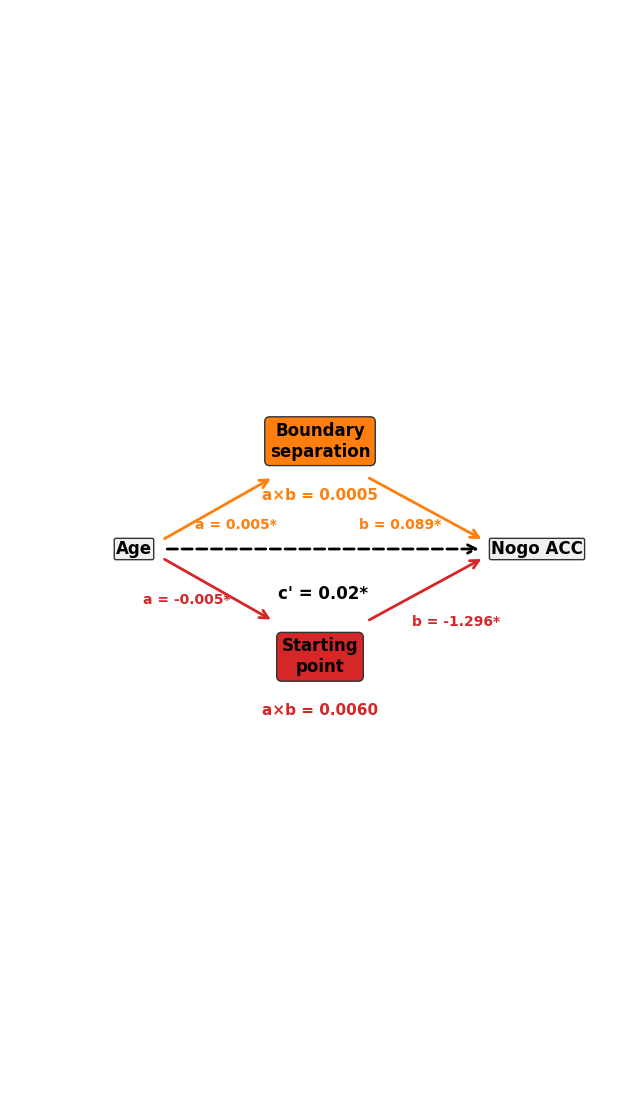

In [4]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np

# Function for formatting p-values
def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# Create directory for saving plots
if not os.path.exists("output"):
    os.makedirs("output")

# Read analysis results
with open('output/model_results-dvalue-gonogo.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# Extract required data
total_effect_coef = results['total_effect']
total_effect_p = results['total_effect_p']
strongest_mediator = results['strongest_mediator']
model_results = results['model_results']
indirect_effects = results['indirect_effects']
direct_effects = results['direct_effects']
proportion_mediated = results['proportion_mediated']
parallel_results = results['parallel_results']

# Filter only significant mediators
all_mediators = list(model_results.keys())
significant_mediators = [m for m in all_mediators if float(parallel_results[m]['p_value']) < 0.05]

# If no significant mediators, show message
if not significant_mediators:
    print("没有发现显著的中介变量 (p < 0.05)")
    plt.figure(figsize=(10, 6))
    plt.text(0.5, 0.5, "No significant mediators found (p < 0.05)", 
             ha='center', va='center', fontsize=16)
    plt.axis('off')
    plt.savefig('./output/combined_mediation_model-dvalue-gonogo.jpg', dpi=1200, bbox_inches='tight')
    plt.show()
else:
    # Define color scheme
    mediator_colors = {
        'v': '#1f77b4',
        'a': '#ff7f0e',
        't': '#2ca02c',
        'z': '#d62728'
    }

    mediator_labels = {
        'v': 'Drift rate',
        'a': 'Boundary\nseparation',
        't': 'Non-decis\nion time',
        'z': 'Starting\npoint'
    }

    node_facecolor = "#f0f0f0"
    node_edgecolor = "#333333"
    arrow_color = "#1f77b4"
    direct_arrow_color = "#ff7f0e"

    # 3. Draw combined mediation model visualization
    plt.figure(figsize=(8, 14))

    # 根据显著中介变量的数量调整位置
    n_sig_mediators = len(significant_mediators)
    
    # 重新定义节点位置，只包含显著的中介变量
    positions = {
        'X': (0.2, 0.5),   # X node position
        'Y': (0.85, 0.5),   # Y node position
    }
    
    # 根据显著中介变量的数量动态调整Y轴位置
    if n_sig_mediators == 1:
        y_positions = [0.5]
    elif n_sig_mediators == 2:
        y_positions = [0.6, 0.4]
    elif n_sig_mediators == 3:
        y_positions = [0.7, 0.5, 0.3]
    else:  # 4 个
        y_positions = [0.71, 0.57, 0.43, 0.29]
    
    # 为显著的中介变量分配位置
    for i, m in enumerate(significant_mediators):
        positions[m] = (0.5, y_positions[i])

    # Node dimensions parameters
    node_width = 0.12       # Width of node boxes
    node_height = 0.07      # Height of node boxes
    main_node_pad = 0.1     # Padding for main nodes (X, Y)
    mediator_node_pad = 0.3 # Padding for mediator nodes

    # Arrow parameters
    arrow_shrink_a = 15     # How much to shrink arrows at start point
    arrow_shrink_b = 15     # How much to shrink arrows at end point
    arrow_width = 2         # Line width for arrows
    arrow_head_size = 15    # Size of arrowheads

    # Mediator node offset parameters (distance from node edge to arrow)
    mediator_offset = 0.05 # Distance from mediator node to arrow start/end

    # Text position adjustment parameters
    a_text_offset_x = {     # X offset for 'a' coefficient text
        'v': -0.01,
        'a': 0.03,
        't': 0.03,
        'z': -0.05
    }
    a_text_offset_y = {     # Y offset for 'a' coefficient text
        'v': 0.04,
        'a': -0.015,
        't': 0.015,
        'z': -0.01
    }
    b_text_offset_x = {     # X offset for 'b' coefficient text
        'v': 0.03,
        'a': -0.04,
        't': -0.015,
        'z': 0.05
    }
    b_text_offset_y = {     # Y offset for 'b' coefficient text
        'v': 0.04,
        'a': -0.015,
        't': 0.015,
        'z': -0.03
    }

    c_text_offset_y = -0.05 # Y offset for 'c' coefficient text

    # Function to get the coordinates of node edges
    def get_edge_point(from_node, to_node):
        # Calculate direction vector
        dx = positions[to_node][0] - positions[from_node][0]
        dy = positions[to_node][1] - positions[from_node][1]
        
        # Normalize
        length = np.sqrt(dx**2 + dy**2)
        dx = dx / length
        dy = dy / length
        
        # Adjust starting position based on node dimensions
        if from_node in ['X', 'Y']:
            # For main nodes (X, Y), consider their rectangular shape
            if abs(dx) > abs(dy):  # Horizontal predominant direction
                # If moving right
                if dx > 0:
                    start_x = positions[from_node][0] + node_width - 0.1
                # If moving left
                else:
                    start_x = positions[from_node][0] 
                start_y = positions[from_node][1]
            else:  # Vertical predominant direction
                start_x = positions[from_node][0]
                # If moving up
                if dy > 0:
                    start_y = positions[from_node][1] + node_height
                # If moving down
                else:
                    start_y = positions[from_node][1] - node_height
        else:
            # For mediator nodes, add offset to ensure gap between node and arrow
            if dx > 0:  # Moving right (towards Y)
                start_x = positions[from_node][0] + mediator_offset
            else:  # Moving left (towards X)
                start_x = positions[from_node][0] - mediator_offset
            
            if dy > 0:  # Moving up
                start_y = positions[from_node][1] + mediator_offset / 2
            elif dy < 0:  # Moving down
                start_y = positions[from_node][1] - mediator_offset / 2
            else:  # Horizontal only
                start_y = positions[from_node][1]
        
        # Adjust ending position based on node dimensions
        if to_node in ['X', 'Y']:
            # For main nodes (X, Y), consider their rectangular shape
            if abs(dx) > abs(dy):  # Horizontal predominant direction
                # If moving right
                if dx > 0:
                    end_x = positions[to_node][0] - node_width + 0.06
                # If moving left
                else:
                    end_x = positions[to_node][0] + node_width
                end_y = positions[to_node][1]
            else:  # Vertical predominant direction
                end_x = positions[to_node][0]
                # If moving up
                if dy > 0:
                    end_y = positions[to_node][1] - node_height
                # If moving down
                else:
                    end_y = positions[to_node][1] + node_height
        else:
            # For mediator nodes, add offset to ensure gap between node and arrow
            if dx > 0:  # Moving right
                end_x = positions[to_node][0] - mediator_offset
            else:  # Moving left
                end_x = positions[to_node][0] + mediator_offset
                
            if dy > 0:  # Moving up
                end_y = positions[to_node][1] - mediator_offset / 2
            elif dy < 0:  # Moving down
                end_y = positions[to_node][1] + mediator_offset / 2
            else:  # Horizontal only
                end_y = positions[to_node][1]
            
        return (start_x, start_y), (end_x, end_y)

    # Draw nodes
    for node, pos in positions.items():
        if node == 'X':
            label = 'Age'
            color = node_facecolor
            bbox_pad = main_node_pad  # Larger padding for main nodes
        elif node == 'Y':
            label = 'Nogo ACC'
            color = node_facecolor
            bbox_pad = main_node_pad  # Larger padding for main nodes
        else:  # Mediator variables
            label = mediator_labels[node]
            color = mediator_colors[node]  # 显著的中介变量使用其对应颜色
            bbox_pad = mediator_node_pad  # Regular padding for mediator nodes
        
        plt.text(pos[0], pos[1], label, 
                 ha='center', va='center', fontsize=12, fontweight='bold',
                 bbox=dict(boxstyle=f'round,pad={bbox_pad}', fc=color, ec=node_edgecolor))

    # Draw paths - only for significant mediators
    # X to mediator paths
    for m in significant_mediators:
        # 显著的中介变量使用其对应颜色
        path_color = mediator_colors[m]
        
        # Get edge coordinates
        start_point, end_point = get_edge_point('X', m)
        
        # Draw the straight arrow
        plt.annotate('', xy=end_point, xytext=start_point, 
                     arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0", 
                                   linewidth=arrow_width, mutation_scale=arrow_head_size, 
                                   shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                                   color=path_color))
        
        # Add coefficient annotation for path a
        midx = (start_point[0] + end_point[0]) / 2
        midy = (start_point[1] + end_point[1]) / 2
        
        # Apply text offsets
        text_x = midx + a_text_offset_x.get(m, 0.03)
        text_y = midy + a_text_offset_y.get(m, 0.015)
        
        # Add path a coefficient
        plt.text(text_x, text_y, 
                 f"a = {model_results[m]['a_coef']:.3f}*",
                 ha='center', va='center', fontsize=10, color=path_color, weight='bold')

    # Mediator to Y paths
    for m in significant_mediators:
        # 显著的中介变量使用其对应颜色
        path_color = mediator_colors[m]
        
        # Get edge coordinates
        start_point, end_point = get_edge_point(m, 'Y')
        
        # Draw the straight arrow
        plt.annotate('', xy=end_point, xytext=start_point, 
                     arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0", 
                                   linewidth=arrow_width, mutation_scale=arrow_head_size, 
                                   shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b,
                                   color=path_color))
        
        # Add coefficient annotation for path b
        midx = (start_point[0] + end_point[0]) / 2
        midy = (start_point[1] + end_point[1]) / 2
        
        # Apply text offsets
        text_x = midx + b_text_offset_x.get(m, -0.015)
        text_y = midy + b_text_offset_y.get(m, 0.015)
        
        # Add path b coefficient
        plt.text(text_x, text_y, 
                 f"b = {model_results[m]['b_coef']:.3f}*",
                 ha='center', va='center', fontsize=10, color=path_color, weight='bold')
        
        # Add a × b annotation above the mediator
        a_coef = model_results[m]['a_coef']
        b_coef = model_results[m]['b_coef']
        ab_value = a_coef * b_coef
        ab_text = f"a×b = {ab_value:.4f}"
        
        # Position slightly above the mediator node
        med_x, med_y = positions[m]
        plt.text(med_x, med_y - 0.05, ab_text, 
                 ha='center', va='center', fontsize=11, fontweight='bold', 
                 color=mediator_colors[m])

    # X to Y direct path (keep this as a dashed line)
    start_point, end_point = get_edge_point('X', 'Y')
    plt.annotate('', xy=end_point, xytext=start_point, 
                 arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=0", 
                               linewidth=arrow_width, linestyle='--', mutation_scale=arrow_head_size, 
                               shrinkA=arrow_shrink_a, shrinkB=arrow_shrink_b, color='black'))

    # Add direct effect coefficient
    direct_midx = (start_point[0] + end_point[0]) / 2
    direct_midy = (start_point[1] + end_point[1]) / 2 + c_text_offset_y
    
    # 使用第一个显著中介变量的直接效应
    plt.text(direct_midx, direct_midy, 
             f"c' = {direct_effects[significant_mediators[0]]:.2f}*",
      fontsize=12, color='black', weight='bold', ha='center', va='bottom')

    # Add legend - only for significant mediators
    legend_elements = []
    for m in significant_mediators:
        # Remove newline characters properly
        clean_label = mediator_labels[m].replace('\n', ' ')
        
        legend_elements.append(
            Patch(facecolor=mediator_colors[m], 
                 label=f'{clean_label}: {proportion_mediated[m]:.1f}% (p={fmt_p(parallel_results[m]["p_value"])})')
        )

    legend_elements.append(Patch(facecolor='none', edgecolor='black', linestyle='--', 
                                 label=f'Direct Effect: {direct_effects[significant_mediators[0]]:.2f}'))

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')


    plt.savefig('./output/combined_mediation_model-dvalue-gonogo.jpg', dpi=1200, bbox_inches='tight')
    plt.show()